<a href="https://colab.research.google.com/github/LilBazil/dino-pic-recognition/blob/main/DinoRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка


Подключение Google Drive к Colab для доступа к папкам и изображениям датасета

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Обновление fastai

In [ ]:
!pip install --upgrade fastai

ERROR: Operation cancelled by user


Импорт библеотек, модулей и настройка вывода графиков

In [ ]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import socket,warnings
import pickle
from fastai.vision import *
from fastai.vision.all import *
from fastai.metrics import error_rate
from fastai.vision.data import ImageDataLoaders
from keras.preprocessing.image import ImageDataGenerator
from fastai.vision.widgets import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Установка переменных

In [ ]:
bs = 64
sz = 256
PATH = '/content/drive/MyDrive/нейронка3/dinosaur_dataset'
path = Path('/content/drive/MyDrive/нейронка3/dinosaur_dataset')

Определение классов в датасете

In [ ]:
classes = []
for d in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'):
        classes.append(d)
print ("Обнаружено классов: ", len(classes), "\n", classes)

Обнаружено классов:  15 
 ['Dilophosaurus', 'Microceratus', 'Ankylosaurus', 'Compsognathus', 'Brachiosaurus', 'Gallimimus', 'Corythosaurus', 'Dimorphodon', 'Pachycephalosaurus', 'Tyrannosaurus_Rex', 'Stegosaurus', 'Velociraptor', 'Parasaurolophus', 'Triceratops', 'Spinosaurus']


In [ ]:
data = ImageDataLoaders.from_folder(PATH, valid_pct=0.2, item_tfms=Resize(sz))
print ("\nОбучающие     ", len(data.train_ds), "\nВалидационные ", len(data.valid_ds))


Обучающие      2160 
Валидационные  539


Определение функций:
* проверки открытия изображения
* получения названия вида

In [ ]:
def can_open_image(fn):
    try:
        img = Image.open(fn)
        return True
    except:
        return False

def get_species(fn):
    return parent_label(fn)

# Осмотр датасета

Отображение графика с выводом 5 названий и изображений вида динозавра

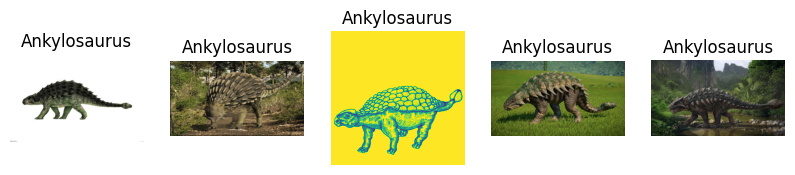

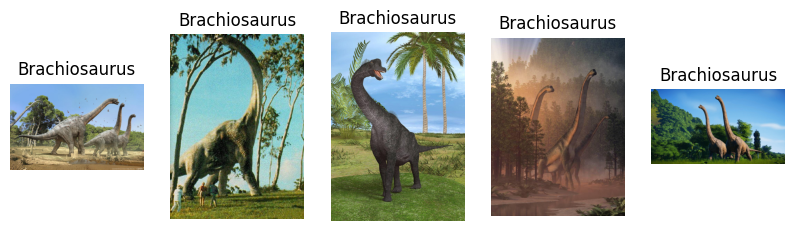

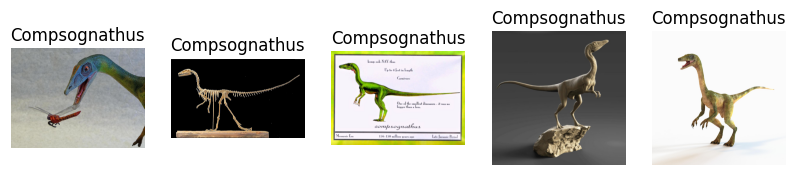

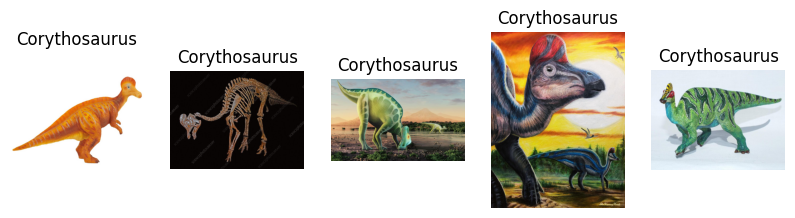

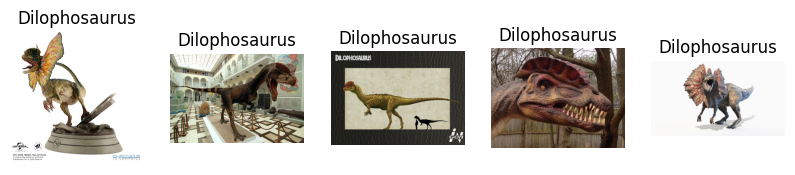

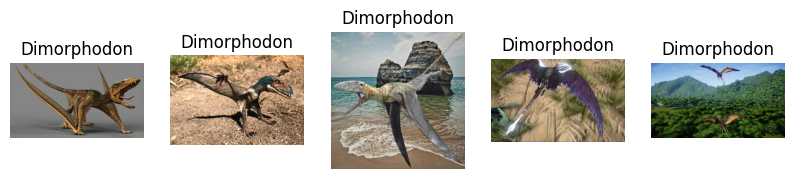

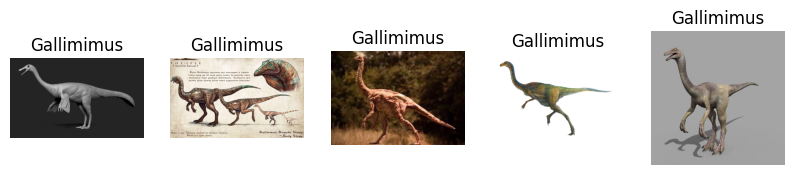

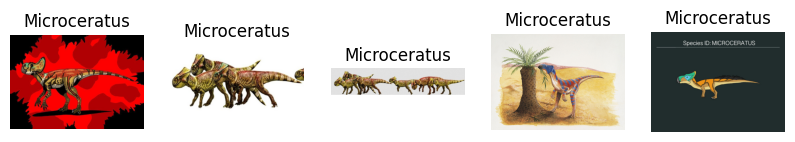

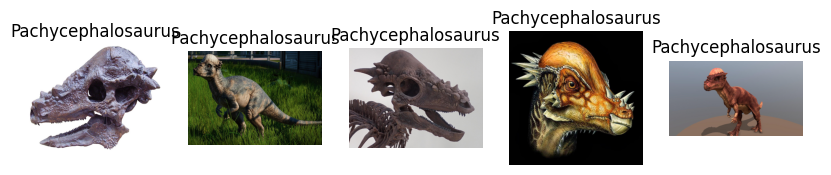

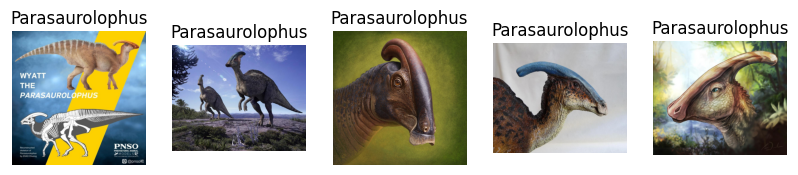

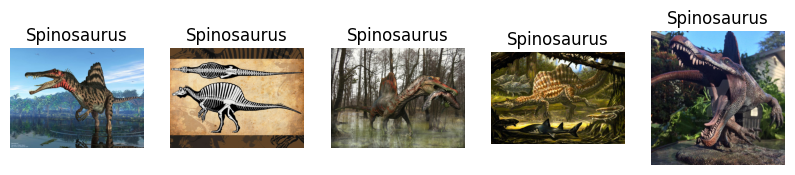

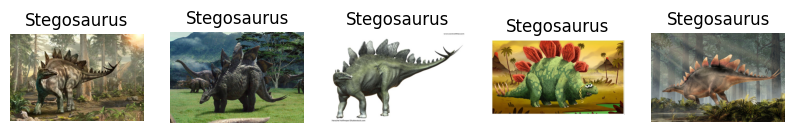

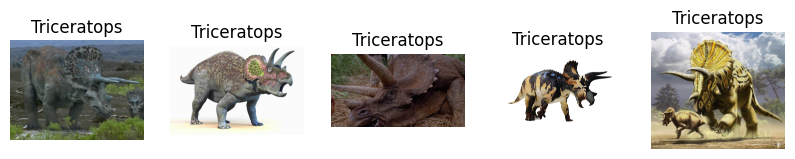

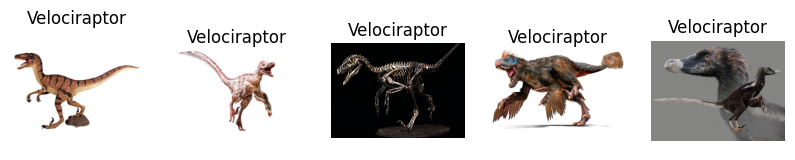

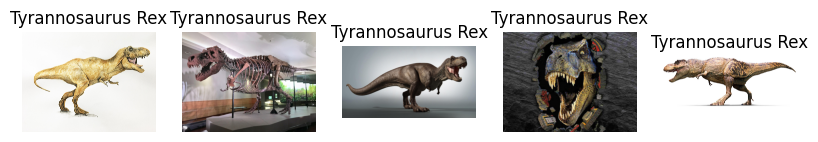

In [ ]:
selected_species = [
    "Ankylosaurus", "Brachiosaurus", "Compsognathus", "Corythosaurus", "Dilophosaurus",
    "Dimorphodon", "Gallimimus", "Microceratus", "Pachycephalosaurus", "Parasaurolophus",
    "Spinosaurus", "Stegosaurus", "Triceratops", "Velociraptor", "Tyrannosaurus Rex"
]

for species in selected_species:
    species_path = path / species.replace(" ", "_")
    image_files = list(species_path.glob('*.jpg'))[:5]
    plt.figure(figsize=(10, 5))

    for i, img_path in enumerate(image_files, 1):
        try:
            img = Image.open(img_path)
            plt.subplot(1, 5, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(species.replace('_', ' '))
        except Exception as e:
            print(f"Не получается открыть изображение: {img_path}: {e}")
    plt.show()

all_images = get_image_files(path, recurse=True).filter(can_open_image)
df = pd.DataFrame({'image': all_images, 'виды': [get_species(fn) for fn in all_images]})
min_count = df['виды'].value_counts().min()
balanced_df = df.groupby('виды').sample(n=min_count, replace=False, random_state=42)

Балансировка датасета

+
функция получения сбалансированных изображений из датасета

In [ ]:
def get_balanced_image_files(path):
    return balanced_df['image'].values

balanced_files = get_balanced_image_files(path)
print(f"Количество изображений в датасете: {len(balanced_files)}")

Количество изображений в датасете: 2685


# Обучение

Определение структуры данных для загрузки и обработки изображений

In [ ]:
if len(balanced_files) > 0:
    dls = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_balanced_image_files,
        splitter=RandomSplitter(valid_pct=0.25, seed=42),
        get_y=parent_label,
        item_tfms=Resize(256),
        batch_tfms=[*aug_transforms(size=128, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(path, bs=64)

Создание модели обучения

+

График для поиска оптимальной скорости обучения



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 107MB/s]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


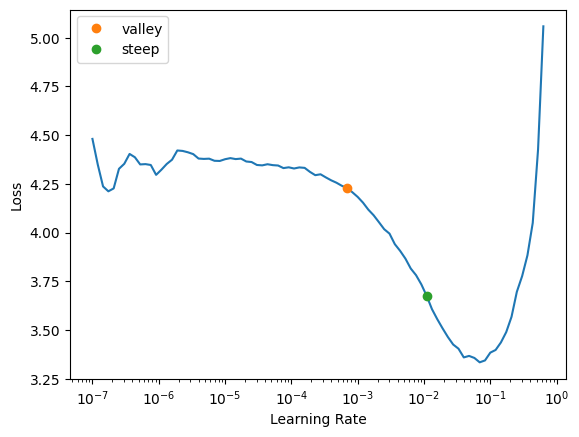

In [ ]:
    learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate])
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))

Обучение модели

+

вывод графика потерь и матрицы ошибок

Better model found at epoch 0 with valid_loss value: 2.152459144592285.


Better model found at epoch 0 with valid_loss value: 1.976835012435913.
Better model found at epoch 1 with valid_loss value: 1.708611249923706.
Better model found at epoch 2 with valid_loss value: 1.4514178037643433.
Better model found at epoch 3 with valid_loss value: 1.2992448806762695.
Better model found at epoch 4 with valid_loss value: 1.184963583946228.
Better model found at epoch 5 with valid_loss value: 1.1265671253204346.
Better model found at epoch 6 with valid_loss value: 1.0723332166671753.
Better model found at epoch 7 with valid_loss value: 1.036468744277954.
Better model found at epoch 8 with valid_loss value: 0.9977705478668213.
Better model found at epoch 9 with valid_loss value: 0.9796597361564636.
Better model found at epoch 10 with valid_loss value: 0.978271484375.
Better model found at epoch 11 with valid_loss value: 0.9699124693870544.


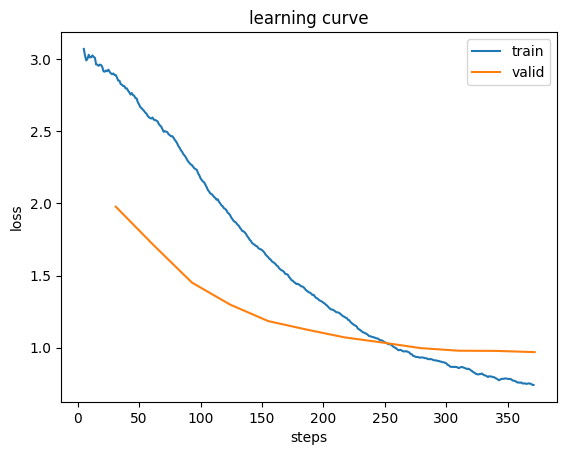

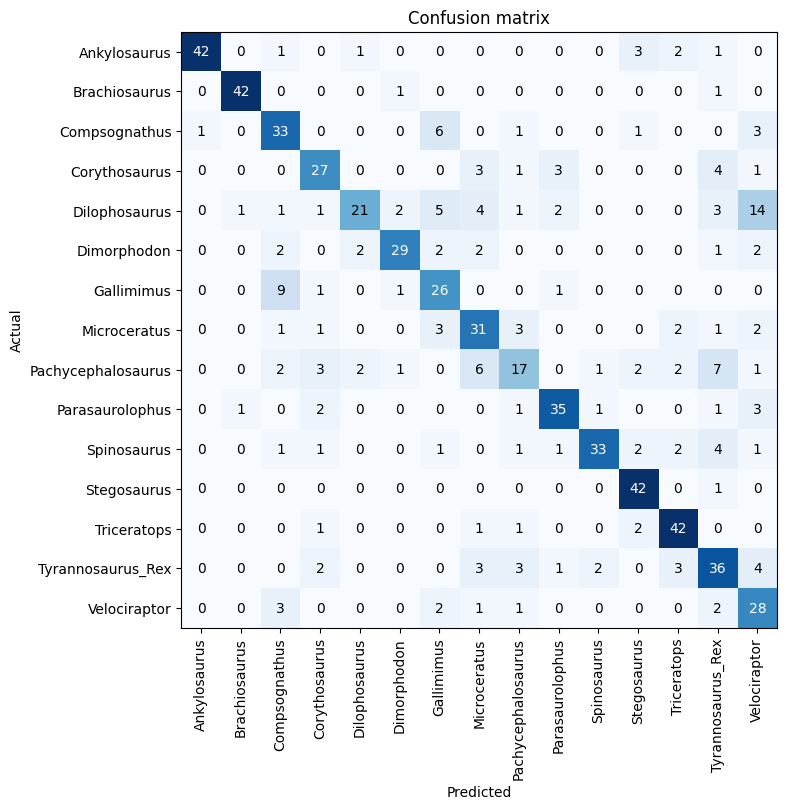

In [ ]:
    try:
        epoch = 12
        learn.fine_tune(epoch, base_lr=lr_min, cbs=[SaveModelCallback()])
    except Exception as e:
        print(f"Ошибка настройки: {e}")

    learn.recorder.plot_loss()
    plt.show()

    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(figsize=(8, 8))

# Работа с моделью

In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

Удаление изображения

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

Перемещение изображения

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Сохранить модель

In [ ]:
learn.save('dino_model')

Path('models/dino_model.pth')

In [ ]:
learn.export('/content/drive/MyDrive/нейронка3/dino_model.pkl')

Загрузить модель

In [ ]:
learn = load_learner('/content/drive/MyDrive/нейронка3/dino_model.pkl')

Микротесты

In [ ]:
def predict_image_class(image_path):
    classes.sort()

    prediction = learn.predict(item=image_path)
    predicted_class = prediction[0]
    probabilities = prediction[2].numpy()
    percentage_chances = [f"{class_name}: {prob*100:.2f}%" for class_name, prob in zip(classes, probabilities)]

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted class: {prediction[0]}")
    plt.show()

    for result in percentage_chances:
        print(result)

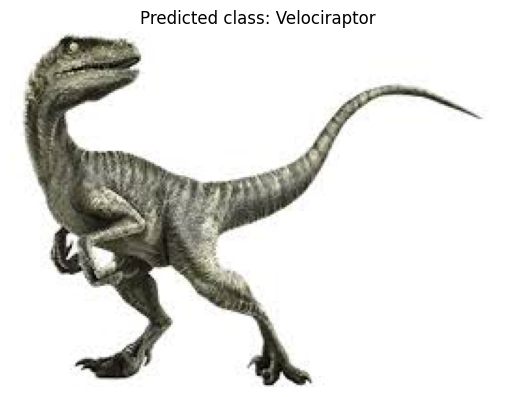

Ankylosaurus: 0.23%
Brachiosaurus: 0.10%
Compsognathus: 0.33%
Corythosaurus: 0.00%
Dilophosaurus: 0.64%
Dimorphodon: 0.09%
Gallimimus: 6.81%
Microceratus: 1.33%
Pachycephalosaurus: 0.51%
Parasaurolophus: 0.01%
Spinosaurus: 0.61%
Stegosaurus: 0.04%
Triceratops: 0.03%
Tyrannosaurus_Rex: 0.10%
Velociraptor: 89.15%


In [ ]:
path = "/content/drive/MyDrive/нейронка3/dinosaur_dataset/Velociraptor_test.jpg"
predict_image_class(path)

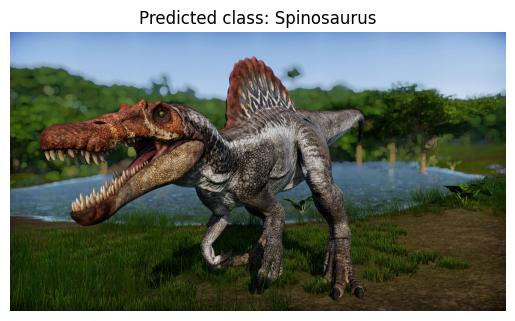

Ankylosaurus: 0.00%
Brachiosaurus: 0.00%
Compsognathus: 0.00%
Corythosaurus: 0.00%
Dilophosaurus: 0.04%
Dimorphodon: 0.00%
Gallimimus: 0.00%
Microceratus: 0.00%
Pachycephalosaurus: 0.01%
Parasaurolophus: 0.00%
Spinosaurus: 99.91%
Stegosaurus: 0.00%
Triceratops: 0.03%
Tyrannosaurus_Rex: 0.01%
Velociraptor: 0.00%


In [ ]:
path = "/content/drive/MyDrive/нейронка3/dinosaur_dataset/Spinosaurus_test.jpg"
predict_image_class(path)

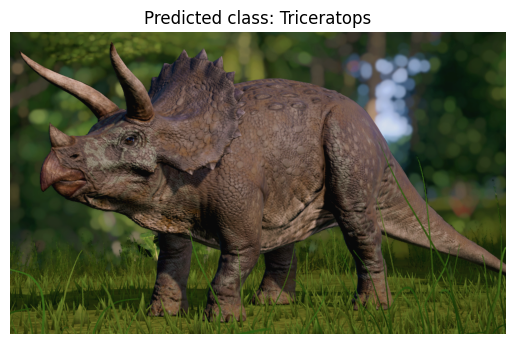

In [ ]:
preds = learn.predict('/content/drive/MyDrive/нейронка3/test_trice1.png')
img = Image.open('/content/drive/MyDrive/нейронка3/test_trice1.png')
plt.imshow(img)

plt.axis('off')
plt.title(f"Predicted class: {preds[0]}")
plt.show()

#Интерфейс

In [2]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.9 MB/

In [3]:
import gradio as gr
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

learn = load_learner('/content/drive/MyDrive/нейронка3/dino_new_model.pkl')

def predict_dinosaur(image):
    img = PILImage.create(image)
    pred, _, probs = learn.predict(img)

    probabilities = probs.numpy()
    sorted_indices = np.argsort(probabilities)[::-1]
    top_5_indices = sorted_indices[:5]
    top_5_classes = [learn.dls.vocab[i] for i in top_5_indices]
    top_5_probabilities = probabilities[top_5_indices]

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.barh(top_5_classes, top_5_probabilities, color='skyblue')
    ax.set_xlim([0, 1])
    ax.set_xlabel('Вкроятности')
    ax.set_title('Какой дино тут вероятнее всего обитает')
    plt.gca().invert_yaxis()

    for i in range(len(top_5_classes)):
        ax.text(top_5_probabilities[i] + 0.02, i, f'{top_5_probabilities[i]:.2f}', va='center')

    return fig

iface = gr.Interface(
    fn=predict_dinosaur,
    inputs=gr.Image(type='pil'),
    outputs=gr.Plot(),
    title="🦖 Что это за дино? 🦕",
    description="Загрузите картинку и я попробую отгадать какой там динозавр. Покажу график с самыми вероятными видами."
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://19c8cd984ba5361603.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
